# Analysis of Citibike bike dock stations

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data
* trips
* stations
* rebalance_pairs
* shapefiles and map tiles

In [ ]:
DATA_DIR = "../data/"
STATIONS_DIR = DATA_DIR + "stations/"
REBALANCE_DIR = DATA_DIR + "rebalance_parquet/"
CRS_WEB_MERCATOR = 3857
CRS_OPENSTREETMAP = "WGS-84"
TRIP_YEAR = 2019

In [ ]:
%%time
trips = helpers.get_trips(TRIP_YEAR, DATA_DIR, convert_dates=True)

CPU times: user 39.2 s, sys: 26.4 s, total: 1min 5s
Wall time: 1min 9s


tripduration               starttime                stoptime  \
0                  320 2019-01-01 00:01:47.401 2019-01-01 00:07:07.581   
1                  316 2019-01-01 00:04:43.736 2019-01-01 00:10:00.608   
2                  591 2019-01-01 00:06:03.997 2019-01-01 00:15:55.438   
3                 2719 2019-01-01 00:07:03.545 2019-01-01 00:52:22.650   
4                  303 2019-01-01 00:07:35.945 2019-01-01 00:12:39.502   
...                ...                     ...                     ...   
20551512           729 2019-10-31 23:59:12.190 2019-11-01 00:11:21.486   
20551513           645 2019-10-31 23:59:17.047 2019-11-01 00:10:02.945   
20551514           257 2019-10-31 23:59:22.514 2019-11-01 00:03:40.260   
20551515           466 2019-10-31 23:59:23.171 2019-11-01 00:07:09.205   
20551516            81 2019-10-31 23:59:51.517 2019-11-01 00:01:13.215   

          startstationid  endstationid  bikeid    usertype  birthyear  gender  
0                   3160          3283   15839  Subscriber       1971       1  
1                    519           518   32723  Subscriber       1964       1  
2                   3171          3154   27451  Subscriber       1987       1  
3                    504          3709   21579  Subscriber       1990       1  
4                    229           503   35379  Subscriber       1979       1  
...                  ...           ...     ...         ...        ...     ...  
20551512             237           311   25725  Subscriber       1995       1  
20551513            3259           461   39583    Customer       1969       0  
20551514            3798           505   21240  Subscriber       1985       1  
20551515             328           361   34916  Subscriber       1989       0  
20551516             539          3093   25745  Subscriber       1990       1  

[20551517 rows x 9 columns]

In [ ]:
# get top N stations by start of trips
stations_by_tripcount = (
    trips.groupby("startstationid")["bikeid"]
    .count()
    .reset_index()
    .rename(columns={"bikeid": "counttrips"})
    .sort_values(by="counttrips", ascending=False)
)

In [ ]:
# read stations
stations = pd.read_csv(STATIONS_DIR + "stations.csv", index_col=0)
stations["stationid"] = stations["stationid"].astype("int64")

In [ ]:
# read boros
# See: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# How convenient, they use NYC boroughs!
boros = gpd.read_file(gpd.datasets.get_path("nybb"))
# add coordinates for boro label. See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
boros = boros.to_crs(epsg=CRS_WEB_MERCATOR)
boros["boro_coords"] = boros["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
boros["boro_coords"] = [coords[0] for coords in boros["boro_coords"]]
bronx_staten_indices = [0, 4]  # not in our analysis scope

In [ ]:
# read rebalance pairs, use TRIP_YEAR alone
rebpairs = pd.read_parquet(
    REBALANCE_DIR + "rebalance_pairs" + helpers.PARQUET_EXTENSION, engine="pyarrow"
)
rebpairs = rebpairs.loc[rebpairs.rebal_year == TRIP_YEAR].drop("rebal_year", axis=1)
rebpairs["stationid_from"] = rebpairs["stationid_from"].astype("int")
rebpairs["stationid_to"] = rebpairs["stationid_to"].astype("int")

In [ ]:
# get sorted list of stations by number of bikes rebalanced (rebalanced from and rebalanced to)
stations_by_rebalcount = rebpairs.sort_values(by="rebal_count", ascending=False)
stations_by_rebalcount_from = list(
    stations_by_rebalcount.stationid_from.drop_duplicates()
)
stations_by_rebalcount_to = list(stations_by_rebalcount.stationid_to.drop_duplicates())

In [ ]:
# get total rebalances (from/to) for a stationid
total_rebal_from = (
    stations_by_rebalcount.groupby("stationid_from")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_from"})
    .sort_values(by="total_rebal_count_from", ascending=False)
)
total_rebal_to = (
    stations_by_rebalcount.groupby("stationid_to")["rebal_count"]
    .sum()
    .reset_index()
    .rename(columns={"rebal_count": "total_rebal_count_to"})
    .sort_values(by="total_rebal_count_to", ascending=False)
)
stations_rebal = (
    pd.merge(
        left=total_rebal_from,
        right=total_rebal_to,
        left_on="stationid_from",
        right_on="stationid_to",
        how="outer",
        validate="1:1",
    )
    .drop("stationid_to", axis=1)
    .rename(columns={"stationid_from": "stationid"})
)

## Stations EDA

In [ ]:
# get number of stations by year to see growth
# map them
# most popular/least + trips
# elevation does it affect stuff
# more

In [ ]:
# get number of all stations ever
stations.shape

(1430, 9)

In [ ]:
def annotate_boros(row):
    """
    Annotate boro names See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    :param row: the boro row
    :return: None
    """
    plt.annotate(
        text=row["BoroName"],
        xy=row["boro_coords"],
        horizontalalignment="left",
        color="Black",
        size=18,
        bbox={
            "boxstyle": "round",
            "facecolor": "white",
            "alpha": 0.8,
            "pad": 0.1,
            "edgecolor": "none",
        },
    )

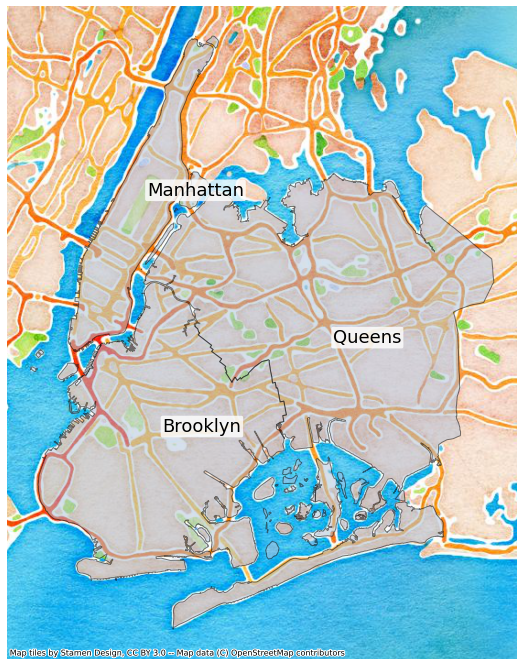

In [ ]:
# plot all 5 boros
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for idx, row in boros.iterrows():
    bronx_staten_indices = [0, 4]  # not in our analysis scope
    boro_color = "indianred" if idx in bronx_staten_indices else "lightsteelblue"
    ax = boros[boros.index == idx].plot(
        alpha=0.5, color=boro_color, edgecolor="k", ax=ax
    )
    annotate_boros()
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")

plt.show()

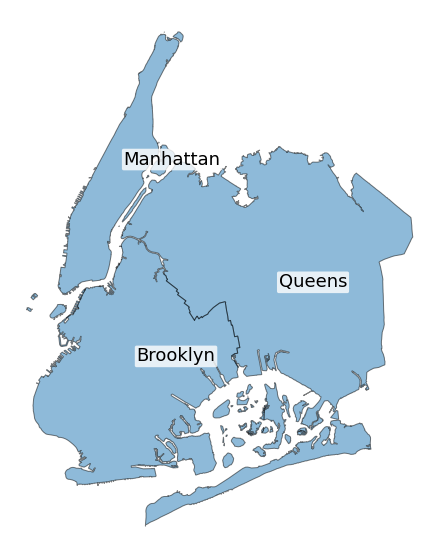

In [ ]:
# drop Staten Island and the Bronx by index
boros.drop(index=[0, 4], inplace=True)
ax = boros.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros()
ax.axis("off")
plt.show()

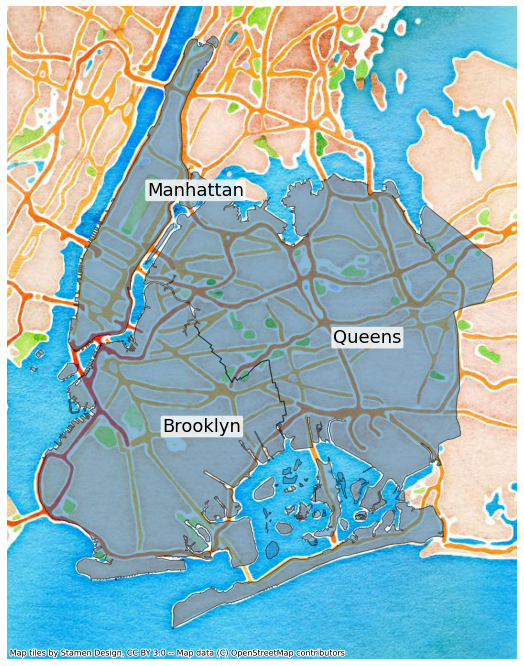

In [ ]:
ax = boros.plot(figsize=(12, 12), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros()
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")
plt.show()

In [ ]:
# drop stations with no latitude or longitude, those in 8D and the Bronx
stations = stations.drop(stations[stations["latitude"] == 0.0].index)
stations = stations.drop(stations[stations["longitude"] == 0.0].index)
stations = stations.drop(stations[stations["boro"] == "Ville-Marie"].index)
stations = stations.drop(stations[stations["boro"] == "The Bronx"].index)

In [ ]:
# merge to get tripcount. NOTE: this drops stations not in TRIP_YEAR
stations = pd.merge(
    left=stations_by_tripcount,
    right=stations,
    how="inner",
    left_on="startstationid",
    right_on="stationid",
).drop("startstationid", axis=1)
stations.insert(0, "stationid", stations.pop("stationid"))

In [ ]:
# add rebalance count (from/to) to stations
stations = pd.merge(left=stations, right=stations_rebal, how="left")

In [ ]:
# create geopandas dataframe and set CRS
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)
)
stations_gdf.crs = CRS_OPENSTREETMAP
stations_gdf = stations_gdf.to_crs(epsg=CRS_WEB_MERCATOR)

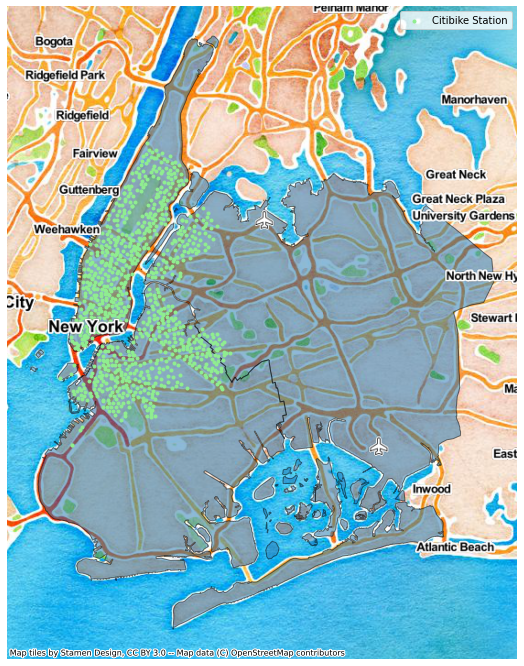

In [ ]:
# plot all stations
# TODO add subway lines https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax = boros.plot(alpha=0.5, edgecolor="k", ax=ax)
ax = stations_gdf.plot(color="lightgreen", ax=ax, label="Citibike Station", marker=".")
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.legend()
ax.axis("off")

plt.show()

### Plot top stations by trip count, rebalances from, and rebalances to


In [ ]:
def plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="SUPTITLE",
    title="SOMETHING",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
):
    """
    Plots the top N stations by column
    :param N:
    :param column_by: one of {"counttrips", "total_rebal_count_from", "total_rebal_count_to"}
    :param title: figure title
    :param legend_label: legend label
    :param focus_manhattan: only draw the boro outline for Manhattan
    :return:
    """
    # plot top stations by tripcount (hint: they're all in Manhattan!)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    # Suptitle too high. See: https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    boro_colors = ["blue", "steelblue", "royalblue"]
    for idx, row in boros.iterrows():
        if focus_manhattan:
            if idx == 3:
                ax = boros[boros.index == idx].plot(
                    alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
                )
        else:
            ax = boros[boros.index == idx].plot(
                alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
            )

        annotate_boros(row)

    # get the top N stations
    stations_gdf_topN = stations_gdf.sort_values(by=column_by, ascending=False).head(N)
    ax = stations_gdf_topN.plot(
        column="counttrips",
        cmap="YlOrRd",
        ax=ax,
        label="Citibike station",
        legend=True,
        legend_kwds={
            "label": legend_label,
            "orientation": "horizontal",
            "pad": 0.01,
            "shrink": 0.5,
            "alpha": 0.5,
        },
    )
    plt.suptitle(suptitle.format(N), fontsize=18)
    plt.title(title)

    cx.add_basemap(ax, source=cx.providers.Stamen.Toner)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
    ax.legend()
    ax.axis("off")

    plt.show()

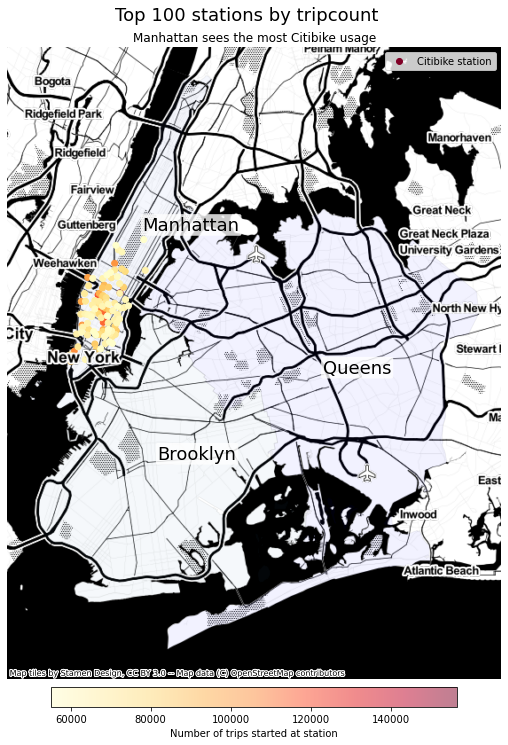

In [ ]:
plot_top_stations(
    N=100,
    column_by="counttrips",
    suptitle="Top {} stations by tripcount",
    title="Manhattan sees the most Citibike usage",
    legend_label="Number of trips started at station",
    focus_manhattan=False,
)

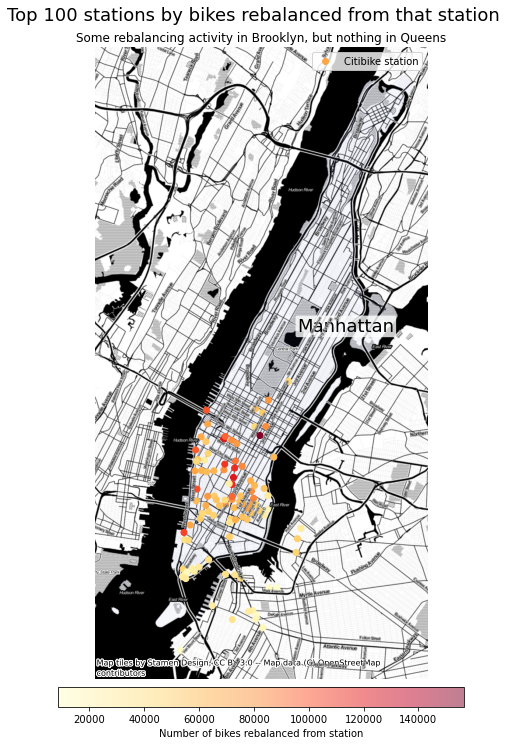

In [ ]:
plot_top_stations(
    N=100,
    column_by="total_rebal_count_from",
    suptitle="Top {} stations by bikes rebalanced from that station",
    title="Some rebalancing activity in Brooklyn, but nothing in Queens",
    legend_label="Number of bikes rebalanced from station",
    focus_manhattan=True,
)

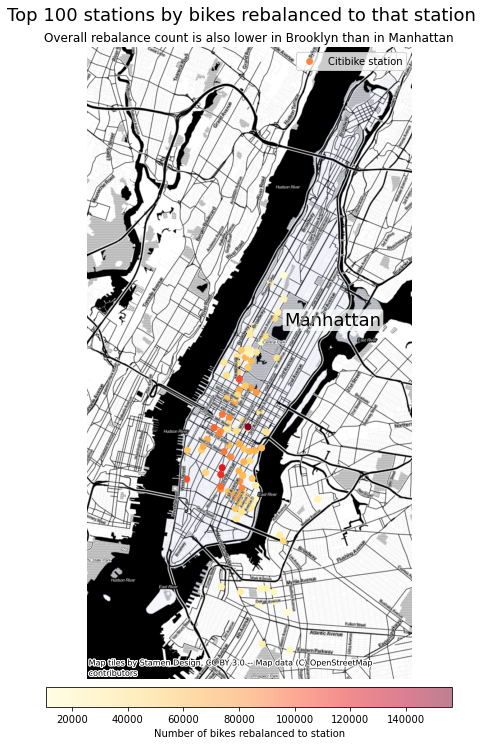

In [ ]:
plot_top_stations(
    N=100,
    column_by="total_rebal_count_to",
    suptitle="Top {} stations by bikes rebalanced to that station",
    title="Overall rebalance count is also lower in Brooklyn than in Manhattan",
    legend_label="Number of bikes rebalanced to station",
    focus_manhattan=True,
)

# Plotly Mapbox

In [ ]:
import plotly.graph_objects as go  # or plotly.express as px

fig = go.Figure()  # or any Plotly Express function e.g. px.bar(...)
# fig.add_trace( ... )
# fig.update_layout( ... )

import dash
from dash import html
from dash import dcc

app = dash.Dash()
app.layout = html.Div([dcc.Graph(figure=fig)])

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/



INFO:__main__:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [ ]:
token = open("../.mapbox_token").read()  # you will need your own token

import pandas as pd

us_cities = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv"
)

import plotly.express as px

fig = px.scatter_mapbox(
    stations_gdf,
    lat="latitude",
    lon="longitude",
    hover_name="stationname",
    hover_data=["counttrips"],
    size="counttrips",
    color_continuous_scale=px.colors.cyclical.IceFire,
    zoom=12,
    height=1200,
)
fig.update_layout(mapbox_style="stamen-watercolor", mapbox_accesstoken=token)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_mapboxes(pitch=30)
fig.show()

In [ ]:
trips.startstationid.value_counts(dropna=False)

519     156575
497     121781
3255    119958
402     113138
285     113012
         ...  
3867         8
3909         6
3245         6
3250         6
488          3
Name: startstationid, Length: 936, dtype: int64